In [5]:
# 라이브러리
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import json
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 책정보 출력

In [6]:
def print_book_info(book_list, book_title):
    book_info = book_list.get(book_title)
    print('제목 : '+ book_info['제목'])
    print('저자 : '+book_info['저자'])
    print('출판사 : '+book_info['출판사'])
    print('출판일 : '+book_info['출판일'])
    print('분류 : '+book_info['분류'])
    print('정가 : '+book_info['정가'])
    reviews = book_info['리뷰']
    if reviews:  # 리뷰가 존재하는 경
        ratings = [review["별점"] for review in reviews]
        print(f'리뷰 평균 : {round(np.mean(ratings), 2)}')
    else:
        print("리뷰 없음")

# 단어 빈도수 wordcloud를 사용하여 시각화

In [7]:
# 특수 문자 제거
def preprocess_text(text):
    return re.sub(r'[^\uAC00-\uD7A3a-zA-Z\s]', '', text)

# wordcloud 시각화
def visualize_reviews_wordcloud(reviews):
    # 형태소 분석기 초기화
    okt = Okt()

    # 모든 리뷰에서 명사 추출
    nouns = []
    for review in reviews:
        clean_review = preprocess_text(review)
        nouns.extend(okt.nouns(clean_review))

    # 단어 빈도수 계산
    word_counts = Counter(nouns)

    # 워드 클라우드 생성
    wordcloud = WordCloud(
        font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
        background_color='white',
        width=800,
        height=400
    ).generate_from_frequencies(word_counts)

    # 시각화
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Review Word Cloud", fontsize=20)
    plt.show()

# 리뷰에서 내용만 골라서 return
def load_reviews_from_book(book_data):
    return [review['내용'] for review in book_data.get('리뷰', [])]

# 코사인 유사도를 사용하여 책 추천

In [8]:
# 책 데이터를 전처리하는 함수
def preprocess_data(book_data):
    """리뷰, 별점, 메타데이터를 추출하여 전처리"""
    books, reviews, ratings, metadata = [], [], [], []

    for book_name, details in book_data.items():
        books.append(book_name)
        # 모든 리뷰 내용을 하나의 문자열로 결합
        book_reviews = " ".join([review["내용"] for review in details.get("리뷰", [])])
        reviews.append(book_reviews)
        
        # 리뷰의 평균 별점 계산
        if "리뷰" in details and details["리뷰"]:
            book_ratings = [review["별점"] for review in details["리뷰"]]
            ratings.append(np.mean(book_ratings))
        else:
            ratings.append(0)  # 리뷰가 없을 경우 별점을 0으로 처리
        
        # 메타데이터(장르, 저자, 출판사) 결합
        metadata.append(f"{details['분류']} {details['저자']} {details['출판사']}")

    return books, reviews, ratings, metadata

# 리뷰와 메타데이터를 벡터화하는 함수
def vectorize_data(reviews, metadata):
    # TF-IDF를 사용하여 리뷰와 메타데이터를 벡터화
    review_vectorizer = TfidfVectorizer()
    review_vectors = review_vectorizer.fit_transform(reviews)

    meta_vectorizer = TfidfVectorizer()
    meta_vectors = meta_vectorizer.fit_transform(metadata)

    return review_vectors, meta_vectors

# 책 추천 함수
def recommend_books(book_name, books, review_vectors, meta_vectors, ratings, review_weight=0.4, metadata_weight=0.4, rating_weight=0.2, top_n=5):
    if book_name not in books:
        return f"'{book_name}'는 데이터에 존재하지 않습니다."

    target_index = books.index(book_name)

    # 유사도 계산
    review_similarity = cosine_similarity(review_vectors[target_index], review_vectors).flatten()
    metadata_similarity = cosine_similarity(meta_vectors[target_index], meta_vectors).flatten()
    normalized_ratings = np.array(ratings) / max(ratings)  # 별점 정규화

    # 가중치를 적용한 유사도 점수 계산
    combined_scores = (
        review_similarity * review_weight +
        metadata_similarity * metadata_weight +
        normalized_ratings * rating_weight
    )

    # 상위 N개의 추천 책 선택
    similar_indices = combined_scores.argsort()[-(top_n + 1):][::-1]
    recommendations = [(books[i], combined_scores[i]) for i in similar_indices if i != target_index]

    return recommendations[:top_n]

# 추천 결과를 출력하는 함수
def display_recommendations(recommendations, target_book):
    print(f"'{target_book}'와(과) 유사한 책 추천:")
    for idx, (book, score) in enumerate(recommendations, start=1):
        print(f"{idx}. {book} (유사도 점수: {score:.2f})")

 이처럼 사소한 것들


제목 : 이처럼 사소한 것들
저자 : 클레어
출판사 : 키건
출판일 : 
분류 : 세계의 소설
정가 : 13,800원
리뷰 평균 : 4.48


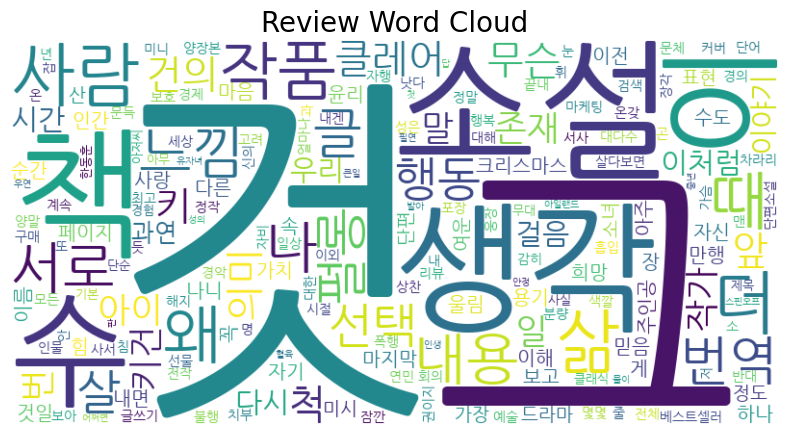

'이처럼 사소한 것들'와(과) 유사한 책 추천:
1. 맡겨진 소녀 (유사도 점수: 0.64)
2. 푸른 들판을 걷다 (유사도 점수: 0.63)
3. 예언자의 노래 (유사도 점수: 0.40)
4. 참을 수 없는 존재의 가벼움 (유사도 점수: 0.37)
5. 타임 셸터 (유사도 점수: 0.36)


In [13]:
if __name__ == "__main__":
    with open('book_list.json', 'r', encoding='utf-8') as file:
        book_list = json.load(file)

    book_title = input()

    if book_title in book_list:
        # 책 제목 입력받기

        print_book_info(book_list, book_title)
    
        # 책 wordcloud 시각화
        reviews = load_reviews_from_book(book_list[book_title])
        visualize_reviews_wordcloud(reviews)

        # 데이터 전처리
        books, reviews, ratings, metadata = preprocess_data(book_list)
        # 리뷰와 메타데이터 벡터화
        review_vectors, meta_vectors = vectorize_data(reviews, metadata)
        # 책 추천 결과 구하기
        recommendations = recommend_books(book_title, books, review_vectors, meta_vectors, ratings)
    else:
        print(f"책 '{book_title}'를 찾을 수 없습니다.")
    # 추천 결과 출력
    display_recommendations(recommendations, book_title)
    